### FEATURES 01: Demographics (Age, Gender, Height)

In [62]:
import pandas as pd
from dfply import *
import matplotlib.pyplot as plt
import missingno as msno
from datetime import timedelta
import sys
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')
import src.utils.utils as utils   # 기타 유틸리티 모듈
import src.data_extraction.access_database as db   # DB 연결 관련 모듈

In [44]:
# 변수를 붙일 subjectlist 데이터 가져오기

data_dir = '../outputs/subjectlist1.csv'
subjectlist = pd.read_csv(data_dir, index_col=0)

# datetime 변환
time_cols = ['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime', 'reintubation_eventtime']
subjectlist = utils.to_datetime(subjectlist, time_cols)
print(subjectlist.shape)
subjectlist.head()

Converted admittime to datetime.
Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
Converted reintubation_eventtime to datetime.
(9003, 27)


,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,...,NaT,NaN,1,False,True,10775.0,10775.0,0.0,11,nonfailure
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,...,NaT,NaN,1,False,True,17365.0,17365.0,0.0,11,nonfailure
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,2144-04-13 17:31:00,NaN,...,NaT,NaN,1,False,True,NaN,0.0,NaN,121,nonfailure
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,...,2144-01-30 13:00:00,30.0,1,False,False,NaN,10035.0,NaN,211,failure
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,NaN,...,NaT,NaN,2,False,True,NaN,0.0,NaN,2221,nonfailure


In [41]:
# DB 연결 테이블 후 가져오기

database_config = {'database': 'mimic4',
 'user': 'postgres',
 'password': '1234',
 'host': 'localhost',
 'port': 5432}

tables_query = {'pg_tables': 'SELECT * FROM PG_TABLES;',
 'patients': 'SELECT * FROM mimiciv_hosp.patients;',
 'd_items': 'SELECT * FROM mimiciv_icu.d_items;'}

db.print_config_info(database_config, tables_query)
conn = db.connect_to_database(database_config)
dataframes = db.retrieve_data(conn, tables_query)
db.disconnect_database(conn)

pg_tables = dataframes['pg_tables']
patients = dataframes['patients']
d_items = dataframes['d_items']

INFO:root:CONNECTING TO DATABASE...
INFO:root:Retrieved pg_tables: (160, 8)


--------- Database Configuration ---------
Database Name: mimic4
User: postgres
Password: ****
Host: localhost
Port: 5432

--------- SQL Queries for Required Tables ---------
pg_tables: SELECT * FROM PG_TABLES;
patients: SELECT * FROM mimiciv_hosp.patients;
d_items: SELECT * FROM mimiciv_icu.d_items;



INFO:root:Retrieved patients: (299712, 6)
INFO:root:Retrieved d_items: (4014, 9)
INFO:root:DATABASE CONNCETION CLOSED.


In [78]:
# subjectlist와 patients demographic (Gender, Anchor_age, Anchor_year) inner join

patients_select = patients >> select(X.subject_id, X.gender, X.anchor_age, X.anchor_year)
subjectlist_joined = subjectlist >> inner_join(patients_select, by='subject_id')


In [77]:
# 나이 계산하는 함수
def calculate_adjusted_anchor_age(df):
    """
    주어진 데이터프레임에 대해 anchor_age를 입원시점에 맞게 조정한 adj_anchor_age을 계산합니다.
    
    이 함수는 'anchor_year'와 'admittime' 컬럼을 사용하여 각 환자의 입원 시점에서의 정확한 연령을 계산합니다.
    계산된 연령은 'adj_anchor_age' 컬럼에 저장됩니다. ('admittime 칼럼은 timestamp로 변환되어 있어야 합니다.')
    
    Parameters:
    - df: pandas DataFrame, 'anchor_year', 'admittime', 'anchor_age' 컬럼을 포함해야 합니다.
    
    Returns:
    - df: 'adj_anchor_age' 컬럼이 추가된 원본 DataFrame의 복사본입니다. 
          계산에 사용된 'anchor_date', 'days_diff', 'years_diff'는 제거됩니다.
    """

    # anchor_date 계산 (앵커 연도의 시작: 1월 1일)
    df['anchor_date'] = pd.to_datetime(df['anchor_year'], format='%Y')
    
    # admittime과 anchor_date 사이의 일수 차이 계산
    df['days_diff'] = (df['admittime'] - df['anchor_date']).dt.days
    
    # 일수 차이를 float 연도로 변환 (윤년 고려해 365.25로 나눔. 더 정확한 나이 표시 가능)
    df['years_diff'] = df['days_diff'] / 365.25
    
    # anchor_age에 연도 차이를 더해 조정된 나이 계산
    df['adj_anchor_age'] = df['anchor_age'] + df['years_diff']
    
    # 조정된 나이를 소수점 둘째 자리까지 반올림
    df['adj_anchor_age'] = df['adj_anchor_age'].round(2)
    
    # 불필요한 컬럼 제거
    df = df.drop(columns=['anchor_date', 'days_diff', 'years_diff'])
    
    return df


In [81]:
subjectlist_joined = calculate_adjusted_anchor_age(subjectlist_joined)

In [90]:
def plot_adj_age(df):
    """
    주어진 데이터프레임에서 'adj_anchor_age'의 분포를 히스토그램으로 그립니다.
    
    Parameters:
    - df: pandas DataFrame, 'adj_anchor_age' 컬럼을 포함해야 합니다.
    """
    # 히스토그램 생성
    plt.figure(figsize=(10, 6))  # 그래프 크기 설정
    plt.hist(df['adj_anchor_age'], bins=30, color='skyblue', edgecolor='black')
    plt.title('adjusted anchor age to admittime(adj_anchor_age)')  # 제목 설정
    plt.xlabel('adjusted age')  # x축 라벨 설정
    plt.ylabel('freq')  # y축 라벨 설정
    plt.grid(axis='y', alpha=0.75)  # y축 그리드 추가

    plt.show()

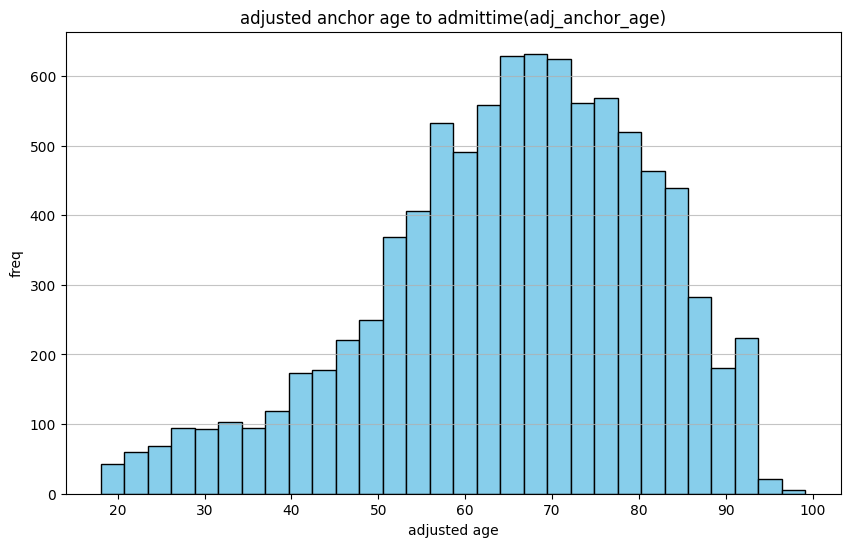

In [91]:
plot_adj_age(subjectlist_joined)

In [22]:
pg_tables.columns

Index(['schemaname', 'tablename', 'tableowner', 'tablespace', 'hasindexes',
       'hasrules', 'hastriggers', 'rowsecurity'],
      dtype='object')

In [26]:
pg_tables[pg_tables.tablename == 'oasis']




,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
150,mimiciv_derived,oasis,postgres,None,False,False,False,False
